In [1]:
import functools
import pickle
import sys

import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")
import matplotlib.pyplot as plt
from trajectory import IsDivergingPrecise, compare_trajectory, plot_trajectory

from common import fitting
from common.hyperparameter import HyperParameter
from common.path import DATA_DIR, FIG_DIR, RESULT_DIR
from modules.utils import prune_state_dict
from train.scheduler import get_scheduler
from train.trainer import rollout
from modules import RungeKutta
from .approximator import HeatApproximator

ImportError: attempted relative import with no known parent package

# Rollout

In [ ]:
device = torch.device("cuda:0")
exp_id = "best_RK"
test_id = "RK4_test"

result_dir = RESULT_DIR / f"heat_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"heat_{test_id}.pkl")

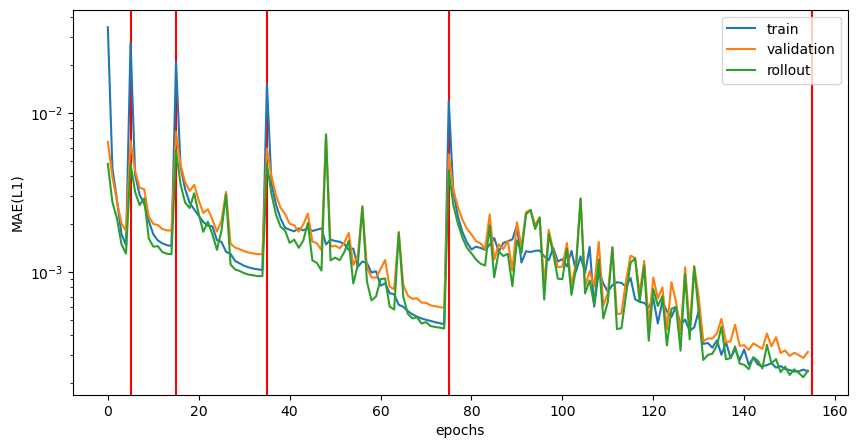

In [4]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [ ]:
approximator = HeatApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

heat_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [5]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(heat_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

# Analyze

In [6]:
times = np.array(
    [np.append(0, np.cumsum(dts.numpy(), dtype=np.float32)) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, er, N=10000 Maximum err: 1.8490e-03 at step=400, node=2608, MAE 6.9933e-05
idx=1, er, N=10000 Maximum err: 1.7737e-03 at step=400, node=2158, MAE 9.6177e-05
idx=2, er, N=10000 Maximum err: 2.0542e-03 at step=400, node=382, MAE 8.4673e-05
idx=3, er, N=10000 Maximum err: 1.8349e-03 at step=400, node=1941, MAE 9.2122e-05
idx=4, rr, N=10000 Maximum err: 1.3956e-03 at step=400, node=1872, MAE 9.5224e-05
idx=5, er, N=10000 Maximum err: 2.6319e-03 at step=400, node=3297, MAE 8.1497e-05
idx=6, er, N=10000 Maximum err: 1.6097e-03 at step=400, node=143, MAE 9.0208e-05
idx=7, rr, N=10000 Maximum err: 1.2514e-03 at step=236, node=5614, MAE 7.5048e-05
idx=8, er, N=10000 Maximum err: 1.8333e-03 at step=400, node=7588, MAE 8.2584e-05
idx=9, rr, N=10000 Maximum err: 1.4061e-03 at step=245, node=2623, MAE 8.5854e-05
idx=10, er, N=10000 Maximum err: 3.0061e-03 at step=400, node=763, MAE 7.8177e-05
idx=11, rr, N=10000 Maximum err: 1.0036e-03 at step=204, node=563, MAE 9.1907e-05
idx=12, ba, N=1000

## Single sample

In [15]:
sample_idx = 3

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0.0, times[sample_idx][-1], 5), 2)
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory

er


plot node with index: [7640 7377 4798  375 5189 7068 2155 9850 4958 8430]


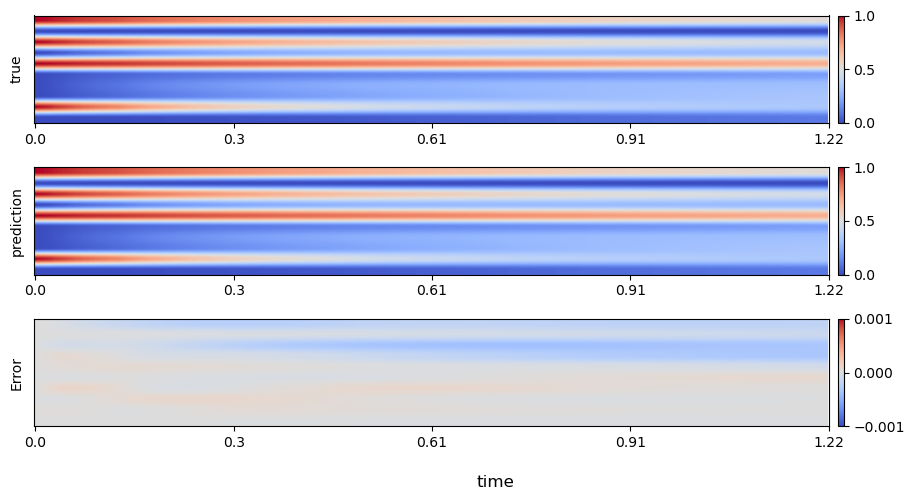

In [17]:
nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 10, replace=False)
# nodes = set()
# # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):
# for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:
#     idx = np.unravel_index(idx, error.shape[1:])
#     nodes.add(idx[0])
#     if len(nodes) == 10:
#         break
nodes = np.array(list(nodes))
print(f"plot node with index: {nodes}")

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)
ax1.set_ylabel("true")
im = plot_trajectory(
    ax1, true_trajcetory, nodes, xticks, cmap="coolwarm", vmin=0.0, vmax=1.0
)
fig.colorbar(im, ax=ax1, location="right", pad=0.01)

ax2.set_ylabel("prediction")
im = plot_trajectory(
    ax2, pred_trajectory, nodes, xticks, cmap="coolwarm", vmin=0.0, vmax=1.0
)
fig.colorbar(im, ax=ax2, location="right", pad=0.01)

ax3.set_ylabel("Error")
im = plot_trajectory(ax3, error, nodes, xticks, cmap="coolwarm", vmin=-0.001, vmax=0.001)
fig.colorbar(im, ax=ax3, location="right", pad=0.01)

fig.supxlabel("time")
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/heat_trajectory.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

## Statisics over samples

slope: 0.0664 pm 0.1604
slope of averaged curve: 0.0807


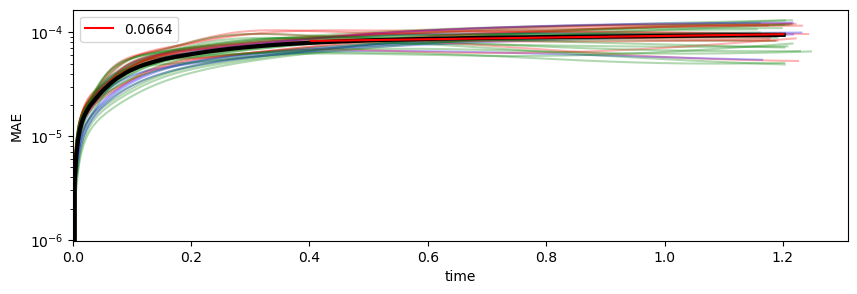

In [8]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 0.4, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    # ax.plot(sample_time, sample_mae, color="gray", alpha=0.3)
    ax.plot(sample_time, sample_mae, color=colors[network_type], alpha=0.3)

    mask = sample_time > fit_range
    if yscale == "log":
        _, _, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        _, _, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)


final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4f} pm {np.std(slopes):.4f}")
print(f"slope of averaged curve: {slope:.4f}")
ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0.0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")
# fig.savefig(f"{FIG_DIR}/heat_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()